In [8]:
import pickle
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import dgl
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import os
import seaborn as sns
sys.path.append("../learning")
from utils import get_seed, get_num_params,  MultipleTensors
from args import get_args
from data_utils import get_model, get_loss_func, MIODataLoader, MIODataset
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from controller import venti_controler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
torch.manual_seed(0)
torch.cuda.empty_cache()

# Load Controller & Models & Data
### take scenario 1 as an example

In [3]:
# Load models
model_paths_all = [
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_00_10_00.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_15_25_04.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0228_15_31_54.pt", 
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0301_16_02_36.pt",
    "../learning/data/checkpoints/co2_all_MIOEGPT_meanvarianceuncertainty_0301_16_03_28.pt", 
]
models_lst = []
device = torch.device('cuda:1')
with torch.no_grad():
    for model_path in model_paths_all:
        result = torch.load(model_path, map_location=torch.device("cuda:1"))
        args = result['args']
        model_dict = result['model']
        model = get_model(args,)
        model.load_state_dict(model_dict)
        model.eval()
        args = result['args']
        models_lst.append(model.to(device))
# Load datas
train_path = "../learning/dataset/train_data_norm.pkl"
dataset_name = "co2"
train_dataset = MIODataset(train_path, name=dataset_name, train=True, train_num=args.train_num, sort_data=args.sort_data, normalize_y=args.use_normalizer,normalize_x=args.normalize_x)
train_loader = MIODataLoader(train_dataset, batch_size=1, drop_last=False)
test_path = 'optimization_data/control_-1.pkl' # scenario: 1
test_dataset = MIODataset(test_path, name=dataset_name, train=False, test_num=args.test_num,
                            sort_data=args.sort_data,
                            normalize_y=args.use_normalizer,
                            normalize_x=args.normalize_x, y_normalizer=train_dataset.y_normalizer,
                            x_normalizer=train_dataset.x_normalizer, up_normalizer=train_dataset.up_normalizer)
test_loader = MIODataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
g, u_p, f = list(iter(test_loader))[0]
controller = venti_controler(models_lst, train_dataset, g, u_p, f, device)

Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Using Linear Attention
Load dataset finished 0.6875207424163818
Training with 3893 samples


/home/jason/anaconda3/envs/ol/lib/python3.9/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Target features are normalized using unit transformer
tensor([[619.4855, 620.2894, 621.0497, 621.8191, 622.4127, 622.9807]]) tensor([[155.6501, 155.7280, 155.7338, 155.8135, 155.9132, 155.9175]])
Target features are normalized using unit transformer
Input features are normalized using unit transformer
Load dataset finished 0.00043392181396484375
Testing with 1 samples
Target features are normalized using unit transformer
Input features are normalized using unit transformer


# Single-step Optimization

100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


action is [[ 75.          1.0811079  86.00483     3.24       77.758354    2.6452694
   88.5942      2.624153  104.216286    1.0462385 115.29658     2.1369965
   88.43361  ]]


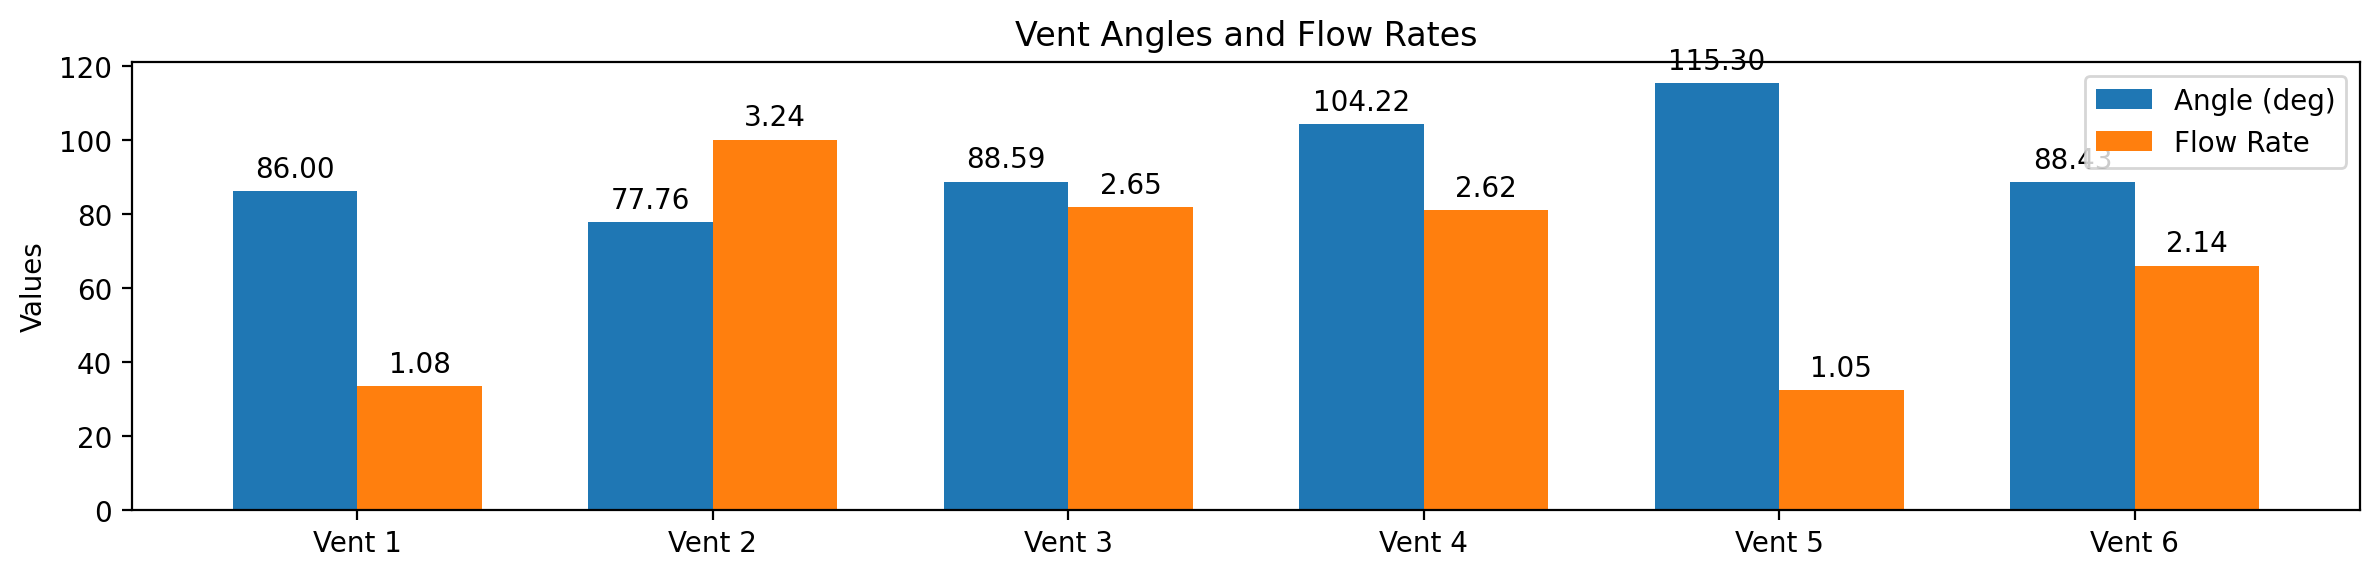

[ 75.          1.0811079  86.00483     3.24       77.758354    2.6452694
  88.5942      2.624153  104.216286    1.0462385 115.29658     2.1369965
  88.43361  ]


In [5]:
optimized_u = controller.solver_grad(g, u_p, f, w1=1, w2=0.12, w3=0.4, epochs=100)
optimized_u = controller.visualize_control(optimized_u)

# Multi-step Optimization

In [13]:
occupants = np.array([75] * 18 + [30] * 18 + [60] * 12 + [40] * 12 + [70] * 12)
energys = []
co2s = []
controls = [] # record all optimized control solutions
g, u_p, f = list(iter(test_loader))[0]
g = g.to(device)
data = pd.read_pickle("optimization_data/unsteady_-1.pkl")
co2_data = data["co2-ppmz-stand"]
co2_data = (np.array(co2_data[:12]).T - 400.)/400. 
co2_data = co2_data[np.newaxis, :]
co2 = []
past_co2 = MultipleTensors([torch.from_numpy(co2_data).float()])
past_co2 = past_co2.to(device)
energy = [0.5] * 12 # because scenario 1 using 12 step for baseline control
co2_high = []
for i in range(10):
    torch.cuda.empty_cache()
    current_t = 12 + i * 6
    occupant = occupants[current_t-12:current_t]
    future_occupant = occupants[current_t:current_t+6]
    print(f"{i}-th step future occupant {future_occupant}")
    with torch.no_grad():
        n_p = torch.ones(1, 13) * future_occupant[-1]
        n_p = controller.up_normalizer.transform(n_p.to(device), inverse=False)
        u_p[0,0] = n_p[0,0]
        u_p = u_p.to(device)
    x_grad = controller.solver_grad(g, u_p, past_co2, w1=1, w2=0.12, w3=0.4,  epochs=30)
    # next round
    new_past_co2 = torch.ones(1, 7492, 12)
    new_past_co2[:,:,:6] = past_co2[0].cpu()[:,:,-6:]
    with torch.no_grad():
        raw = controller.get_raw(x_grad)
        energy += [raw[0, 1::2].sum() / 3.24 / 6] * 6
        controls.append(raw)
        mu, std = controller.get_prediction(g, x_grad, past_co2)
        predict_co2 = controller.y_normalizer.transform(mu)
        predict_co2 = (predict_co2 - 400. ) / 400. # we norm the data for input
        predict_co2 = predict_co2.detach().cpu().unsqueeze(0)
        new_past_co2[:,:,6:] = predict_co2
        u_p = x_grad.detach().cpu()
        past_co2 = MultipleTensors([new_past_co2]).to(device)
        co2.append(new_past_co2[:,:,6:].detach().squeeze().numpy())
    del x_grad, mu, std, n_p 
    torch.cuda.empty_cache()
energys.append(energy)

0-th step future occupant [75 75 75 75 75 75]


100%|██████████| 30/30 [00:01<00:00, 15.81it/s]


action is [[ 75.          1.4591651  94.90076     2.4665928  87.55551     2.5124326
   98.45541     2.5748618  92.62011     1.6453183 111.835175    2.531603
   80.82654  ]]
1-th step future occupant [30 30 30 30 30 30]


100%|██████████| 30/30 [00:01<00:00, 15.45it/s]


action is [[ 30.          1.7709244  96.733665    2.7658057  85.70894     2.0899572
   85.92834     1.5486865  88.181694    1.3858725 114.53593     1.8252537
   86.51887  ]]
2-th step future occupant [30 30 30 30 30 30]


100%|██████████| 30/30 [00:01<00:00, 15.88it/s]


action is [[ 30.          1.8999109 104.56439     2.741402   83.6656      1.7211754
   85.96892     1.1430886  86.92886     1.5273702 116.75651     1.7408266
   81.555954 ]]
3-th step future occupant [30 30 30 30 30 30]


100%|██████████| 30/30 [00:01<00:00, 15.65it/s]


action is [[ 30.           2.213328   110.41385      2.4768395   85.15924
    1.5771105   79.77602      0.36019814  81.33608      1.9813281
  117.32195      2.10687     71.3262    ]]
4-th step future occupant [60 60 60 60 60 60]


100%|██████████| 30/30 [00:01<00:00, 16.13it/s]


action is [[ 60.          2.6976743 121.28686     2.1507955  80.43715     1.0551167
   81.76418     0.324      71.95464     0.9311632 115.276695    2.7175848
   67.81673  ]]
5-th step future occupant [60 60 60 60 60 60]


100%|██████████| 30/30 [00:01<00:00, 15.69it/s]


action is [[ 60.           3.2250757  129.6926       2.208181    73.188416
    0.38510573  84.7337       0.324       60.49789      0.324
  118.470726     2.345882    68.13283   ]]
6-th step future occupant [40 40 40 40 40 40]


100%|██████████| 30/30 [00:01<00:00, 16.25it/s]


action is [[ 40.          3.24      135.          1.8069718  77.46346     0.324
   89.0639      0.324      49.123028    0.324     119.98215     1.4912671
   60.21692  ]]
7-th step future occupant [40 40 40 40 40 40]


100%|██████████| 30/30 [00:01<00:00, 15.45it/s]


action is [[ 40.          3.24      135.          1.7922987  80.203186    0.324
   93.89943     0.324      45.          0.324     121.51756     1.457218
   55.29397  ]]
8-th step future occupant [70 70 70 70 70 70]


100%|██████████| 30/30 [00:01<00:00, 16.08it/s]


action is [[ 70.          3.24      135.          2.6444335  72.108       0.324
   93.513115    0.324      45.          0.324     128.21527     2.3425012
   49.77138  ]]
9-th step future occupant [70 70 70 70 70 70]


100%|██████████| 30/30 [00:01<00:00, 16.16it/s]

action is [[ 70.          3.24      135.          2.7214816  67.798965    0.324
   88.49085     0.324      45.          0.324     133.89766     2.479422
   47.875732 ]]


# Visualize results
Note 1.   
We use np.quantile(data, 0.99) to measure the peak data.

Note 2.   
Below data is validated by ANSYS Fluent, using the above control solutions.   

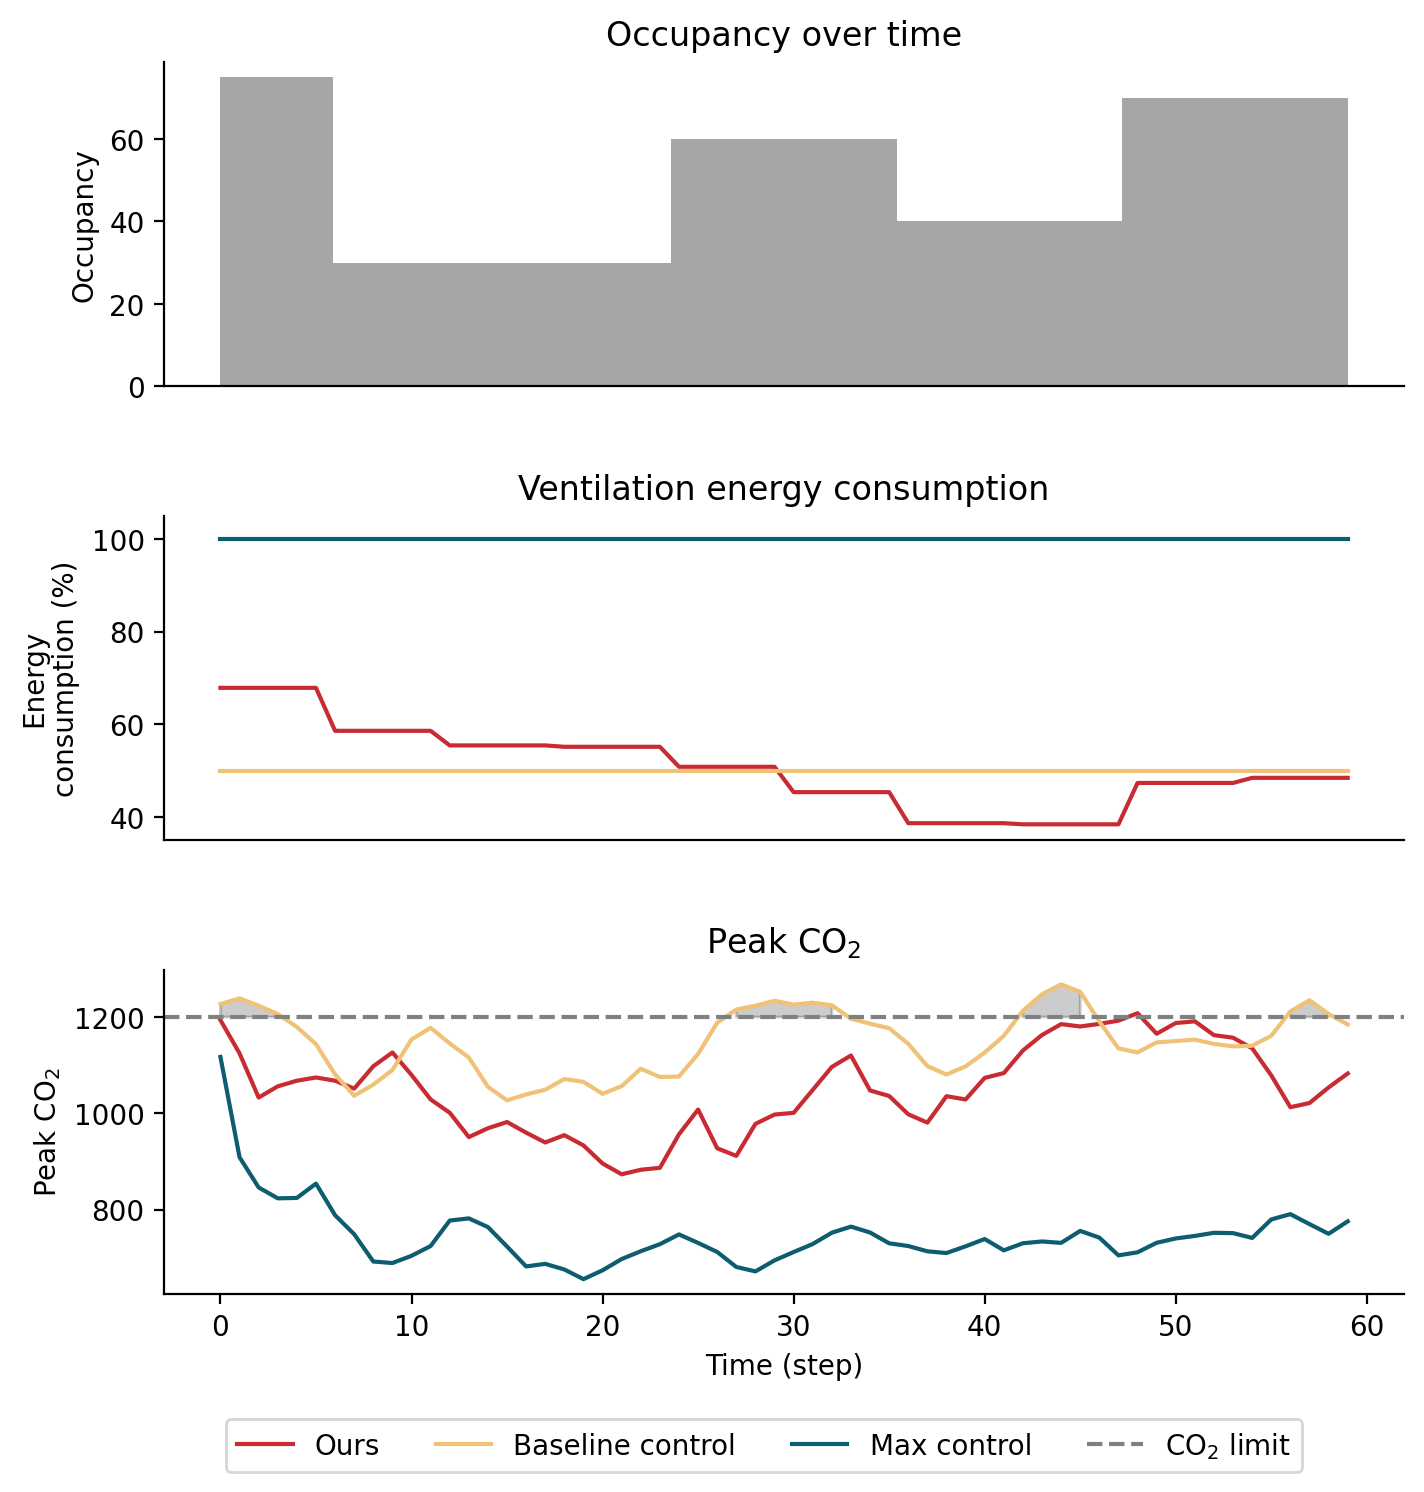

In [22]:
# prepare the data
co2_limit = 1200
paths = ["optimization_data/unsteady_mpcoptimize.pkl", "optimization_data/unsteady_mpcbaseline.pkl", "optimization_data/unsteady_mpcmax.pkl"]
occupants = np.array([75] * 18 + [30] * 18 + [60] * 12 + [40] * 12 + [70] * 12)
co2_datas = []
energys = []
for i, p in enumerate(paths):
    data = pd.read_pickle(p)
    co2_data = np.array(data["co2-ppmz-stand"])
    co2_datas.append(co2_data)
    energy = np.repeat(data["u"][:,1::2].sum(axis=1) / 3.24 / 6 * 100, 6)
    energys.append(energy)
time = np.arange(60)
# plot
colors = [ "#c92b32","#efc278", "#0d5c70"]
methods = ["Ours", "Baseline control", "Max control"]
fig, ax = plt.subplots(3,1, figsize=(8,8))
ylabels = ["Occupancy", "Energy\nconsumption (%)", r"Peak CO$_2$"]
# occupancy 
ax[0].bar(np.arange(60), occupants[12:], color="gray", width=1, alpha=0.7)
ax[0].set_title("Occupancy over time")
# energy and co2
for i in range(3):
    ax[1].plot(energys[i], color=colors[i], label=methods[i])
    ax[1].set_ylim(35, 105)
    ax[1].set_title("Ventilation energy consumption")
    ax[2].plot(np.quantile(co2_datas[i], 0.99, axis=1), color=colors[i], label=methods[i])
    ax[2].set_title(r"Peak CO$_2$")
ax[2].axhline(co2_limit, color='gray', linestyle='--', label='CO$_2$ limit')
co2_baseline = np.quantile(co2_datas[1], 0.99, axis=1)
violation_mask = co2_baseline > co2_limit
ax[2].fill_between(time, co2_limit, co2_baseline, where=violation_mask, color='black', alpha=0.2)
ax[2].set_xlabel("Time (step)")
# Shared legend below all subplots
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.01))
for i in range(3):
    ax[i].set_ylabel(ylabels[i])
    if i != 2: ax[i].set_xticks([])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()